### Importing Required Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Setting up Paths for Training Images and Labels

In [2]:
import os
root = './dataset'
print(os.listdir(root))
train = os.path.join(root, "train")
train_imgs = os.listdir(train)
train_labels = os.path.join(root, "train_label")

['train', 'train_label', 'val', 'val_label']


### Loading and Displaying a Training Image and its Label

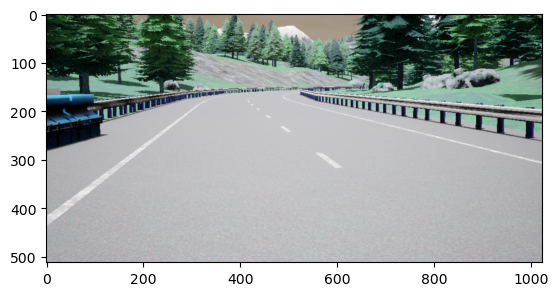

In [3]:
img = plt.imread(os.path.join(root, "train", train_imgs[0]))
plt.imshow(img)
plt.show()

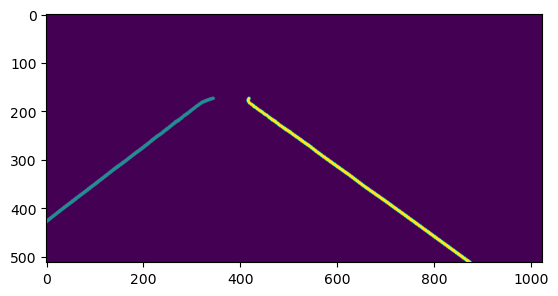

In [4]:
label_images = os.listdir(train_labels)
img = plt.imread(os.path.join(root, "train_label", label_images[0]))
plt.imshow(img)
plt.show()

In [5]:
# Printing File Names

print(label_images[0])
print(train_imgs[0])

Town04_Clear_Noon_09_09_2020_14_57_22_frame_0_label.png
Town04_Clear_Noon_09_09_2020_14_57_22_frame_0.png


### Setting up Paths for Train,Validation Images and Labels

In [6]:
DATA_DIR = './dataset'

x_train_dir = os.path.join(DATA_DIR, "train")
y_train_dir = os.path.join(DATA_DIR, 'train_label')


x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_label')

### Visualizing Multiple Images with Custom Titles

In [7]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### CarlaLanesDataset Class for Lane Detection

In [8]:
from torch.utils.data import DataLoader, Dataset
from torch import LongTensor

In [9]:
import re
import cv2

class CarlaLanesDataset(Dataset):
    """ Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background', 'left_marker', 'right_marker']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        #random.shuffle(self.ids)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        get_label_name = lambda fn: re.sub(".png", "_label.png", fn)
        self.masks_fps = [os.path.join(masks_dir, get_label_name(image_id)) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, LongTensor(mask)
        
    def __len__(self):
        return len(self.ids)

### Sample Visualization from CarlaLanesDataset

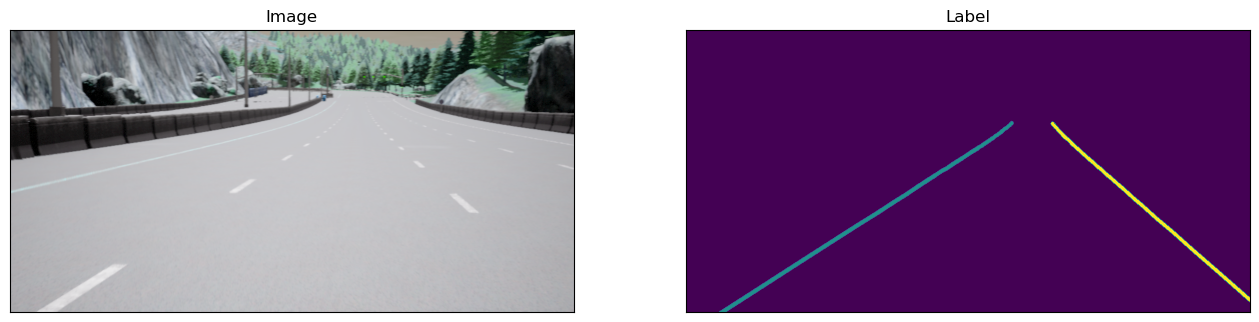

In [10]:
dataset = CarlaLanesDataset(x_train_dir, y_train_dir, classes=CarlaLanesDataset.CLASSES)

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    label = mask
)

### Augmentation and Preprocessing Functions for Lane Detection

In [11]:
import albumentations as albu
def get_training_augmentation():
    train_transform = [
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0., shift_limit=0.1, p=1, border_mode=0),

        albu.IAAAdditiveGaussianNoise(p=0.2),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.6,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.6,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.6,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    return None

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):   
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)


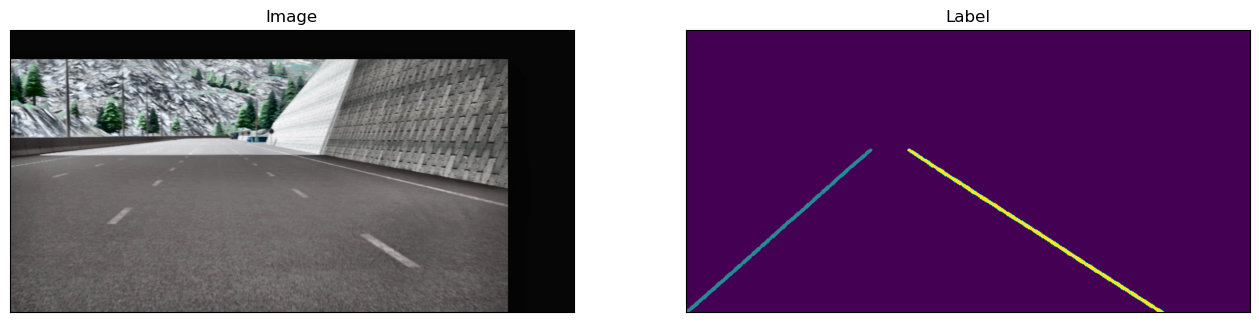

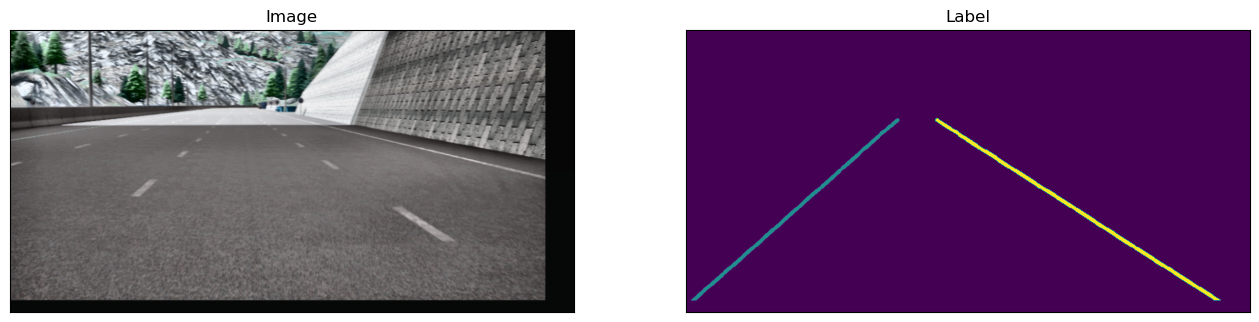

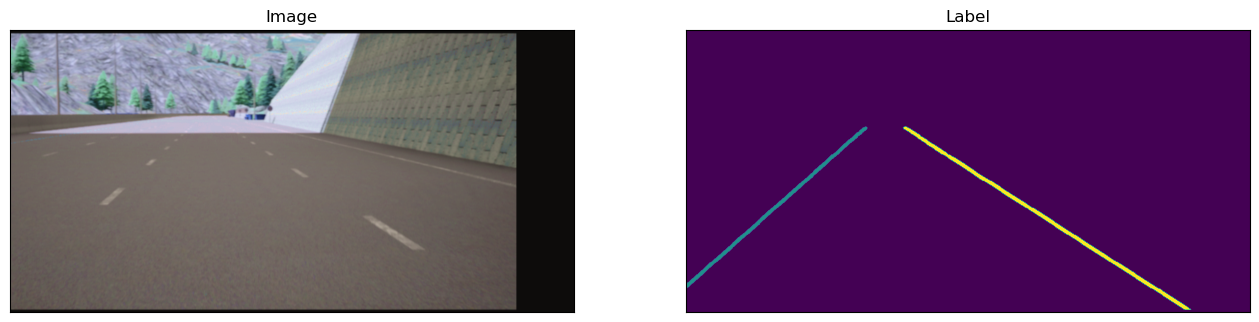

In [12]:
#### Visualize resulted augmented images and masks

augmented_dataset = CarlaLanesDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=CarlaLanesDataset.CLASSES,
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, label=mask)

### Setting Up a Segmentation Model with Pretrained Encoder for Lane Detection

In [13]:
import torch
import segmentation_models_pytorch as smp

loss_string = 'multi_dice_loss'

ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CarlaLanesDataset.CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

### Initializing Training and Validation Datasets for Lane Detection

In [14]:
train_dataset = CarlaLanesDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CarlaLanesDataset.CLASSES,
)

valid_dataset = CarlaLanesDataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CarlaLanesDataset.CLASSES,
)

### Creating Data Loaders for Training and Validation Datasets

In [15]:
bs_train = 8 
bs_valid = 8 
train_loader = DataLoader(train_dataset, batch_size=bs_train, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=bs_valid, shuffle=False)

### MultiDiceLoss Class for Lane Detection

In [16]:
from segmentation_models_pytorch.utils import base
from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import Accuracy

label_left = CarlaLanesDataset.CLASSES.index('left_marker')
label_right = CarlaLanesDataset.CLASSES.index('right_marker')

class MultiDiceLoss(base.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.BinaryDiceLossLeft = DiceLoss()
        self.BinaryDiceLossRight = DiceLoss()
        
    def forward(self, y_pr, y_gt):
        left_gt = (y_gt == label_left)
        right_gt = (y_gt == label_right)
        loss_left = self.BinaryDiceLossLeft.forward(y_pr[:,label_left,:,:] , left_gt)
        loss_right = self.BinaryDiceLossRight.forward(y_pr[:,label_right,:,:] , right_gt)
        return (loss_left + loss_right)*0.5

### Setting Up Metrics, Loss Function, and Optimizer for Lane Detection Model Training

In [17]:
metrics = []
loss = MultiDiceLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [18]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### Training Loop for Lane Detection Model

In [ ]:
best_loss = 1e10

for i in range(0, 1):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if best_loss > valid_logs[loss_string]:
        best_loss = valid_logs[loss_string]
        torch.save(model, './best_model_{}.pth'.format(loss_string))
        print('Model saved!')
        
    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [19]:
best_model = torch.load('./best_model_multi_dice_loss.pth')

### Evaluating the Best Model on a Test Dataset

In [20]:
test_best_model = True
if test_best_model:
    # create test dataset
    test_dataset = CarlaLanesDataset(
        x_valid_dir, 
        y_valid_dir, 
        augmentation=get_validation_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CarlaLanesDataset.CLASSES,
    )

    test_dataloader = DataLoader(test_dataset)

    # evaluate model on test set
    test_epoch = smp.utils.train.ValidEpoch(
        model=best_model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
    )

    logs = test_epoch.run(test_dataloader)

valid: 100%|███████████████████████████████████████████████| 129/129 [00:27<00:00,  4.71it/s, multi_dice_loss - 0.2267]


In [21]:
# test dataset without transformations for image visualization
test_dataset_vis = CarlaLanesDataset(
    x_valid_dir, y_valid_dir, 
    classes=CarlaLanesDataset.CLASSES,
    preprocessing=get_preprocessing(preprocessing_fn)
)

### Visualizing Predictions from the Best Model on Random Test Samples

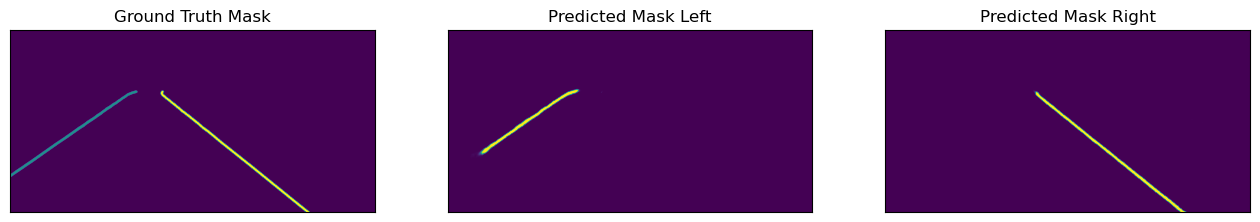

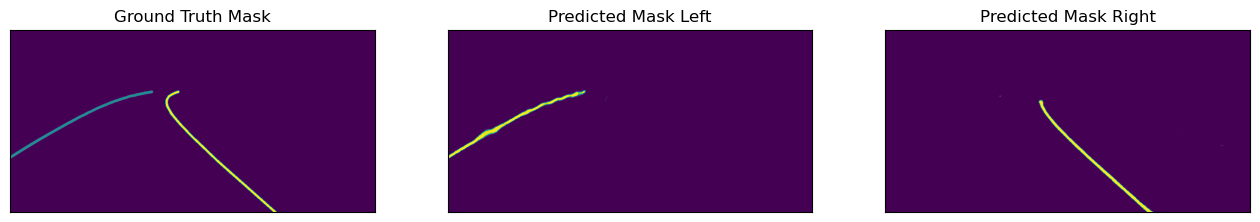

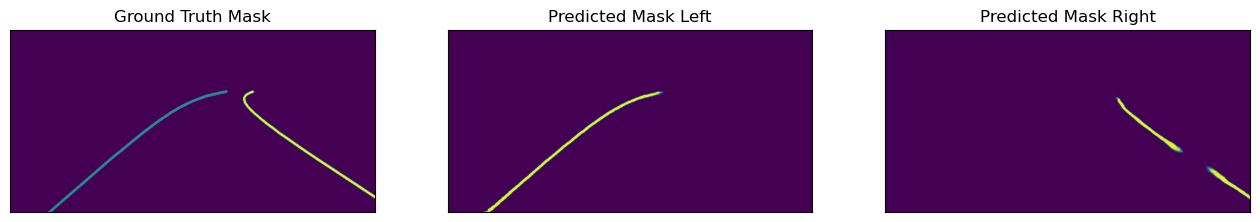

In [22]:
for i in range(3):
    n = np.random.choice(len(test_dataset_vis))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset_vis[n]
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask_left = best_model.predict(x_tensor)[0,1,:,:] 
    pr_mask_left = (pr_mask_left.cpu().numpy())

    pr_mask_right = best_model.predict(x_tensor)[0,2,:,:] 
    pr_mask_right = (pr_mask_right.cpu().numpy())
        
    visualize( 
        ground_truth_mask=gt_mask, 
        predicted_mask_left=pr_mask_left,
        predicted_mask_right=pr_mask_right
    )

### Processing a video file to detect and visualize lane markings using our deep learning model

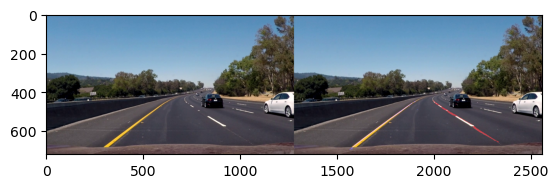

In [23]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as albu
from IPython.display import clear_output

# Load your trained model
best_model = torch.load('./best_model_multi_dice_loss.pth')
best_model.eval()

# Input and output video file paths
input_video_path = 'test_video.mp4'  
output_video_path = 'output_video.mp4'  

# Open the input video file
cap = cv2.VideoCapture(input_video_path)

# Get input video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Pad the input image dimensions to be divisible by 32
padded_height = ((height - 1) // 32 + 1) * 32
padded_width = ((width - 1) // 32 + 1) * 32

# Adjust the output video size to accommodate side-by-side frames
output_width = 2 * width  # Double the width to place two frames side by side
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (output_width, height))

# Define the classes and preprocessing function
class_names = ['background', 'left_marker', 'right_marker']

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

preprocessing_fn = smp.encoders.get_preprocessing_fn('efficientnet-b0', 'imagenet')

def get_preprocessing():
    _transform = [
        albu.PadIfNeeded(min_height=padded_height, min_width=padded_width),
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

preprocessing = get_preprocessing()

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame
        preprocessed_frame = preprocessing(image=frame)['image']
        x_tensor = torch.from_numpy(preprocessed_frame).unsqueeze(0).to('cuda')

        # Predict lane masks
        with torch.no_grad():
            pr_masks = best_model.predict(x_tensor)

        # Process the predicted masks
        threshold = 0.5
        lane_left = (pr_masks[0, 1, :, :] > threshold).cpu().numpy().astype(np.uint8) * 255
        lane_right = (pr_masks[0, 2, :, :] > threshold).cpu().numpy().astype(np.uint8) * 255

        # Resize lane masks to match the frame dimensions
        lane_left = cv2.resize(lane_left, (width, height))
        lane_right = cv2.resize(lane_right, (width, height))

        # Create an empty canvas and draw lanes
        lane_detection = np.zeros_like(frame)
        lane_detection[:, :, 0] = lane_left  # Red channel for left lane
        lane_detection[:, :, 2] = lane_right  # Blue channel for right lane

        # Blend the lane detection with the original frame
        result_frame = cv2.addWeighted(frame, 1, lane_detection, 0.5, 0)

        # Combine original frame and result_frame side by side
        combined_frame = np.hstack((frame, result_frame))

        # Display the combined frame using Matplotlib
        clear_output(wait=True)
        plt.imshow(cv2.cvtColor(combined_frame, cv2.COLOR_BGR2RGB))
        plt.show()

        # Write the combined frame to the output video file
        out.write(combined_frame)

except KeyboardInterrupt:
    pass
finally:
    # Release resources
    cap.release()
    out.release()
